<a href="https://colab.research.google.com/github/ranjan2829/Algorithm-trading-Strategies/blob/main/Volatility_Prediction_Model_BlackRock_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

In [18]:
def BuildDataSet(pct):
  Window=150
  result=[]
  for i in range(Window,len(pct)):
    hold=pct[i-Window:i]
    result.append(np.std(hold))
  return result


In [38]:
def BuildTrainTest(vol):
    window = 100  # Matches the input size of the model
    output = 30   # Output prediction size
    inputs = []
    outputs = []
    for i in range(window, len(vol)-output+1):
        inp_ = vol[i-window:i]  # Create input slices of size 100
        out_ = vol[i:i+output]  # Create output slices of size 30
        inputs.append(inp_)
        outputs.append(out_)
    IN = [torch.tensor(i, dtype=torch.float32) for i in inputs]
    OUT = [torch.tensor(i, dtype=torch.float32) for i in outputs]
    TEST = [torch.tensor(vol[-window:], dtype=torch.float32)]
    return torch.stack(IN), torch.stack(OUT), torch.stack(TEST)


In [40]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputs, outputs):
        super(NeuralNetwork, self).__init__()
        self.layer = nn.Linear(inputs, 100)
        self.layer2 = nn.Linear(100, 100)  # Changed output size to match next layer input
        self.layer3 = nn.Linear(100, outputs)  # Fixed capitalization and made final output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)  # Fixed capitalization
        return x

In [41]:
class Normalize:
  def __init__(self):
    self.minx=None
    self.maxx=None
  def normalize(self,x):
    x=np.array(x)
    self.minx=np.min(x)
    self.maxx=np.max(x)
    return (x-self.minx)/(self.maxx-self.minx)
  def denormalize(self,x):
    return x*(self.maxx-self.minx)+self.minx


In [42]:
normal=Normalize()
model=NeuralNetwork(100,30)
data=pd.read_csv("BLK.csv")[::-1]
close=data['adjClose'].values
delta=close[1:]/close[:-1]-1.0
volatility=BuildDataSet(delta)
nVol=normal.normalize(volatility)
TIN,TOUT,TTEST=BuildTrainTest(nVol)
learning_rate=0.001
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.MSELoss()

In [43]:
print("TIN shape:", TIN.shape)  # Should be (batch_size, 100)
print("TOUT shape:", TOUT.shape)  # Should be (batch_size, 30)


TIN shape: torch.Size([978, 100])
TOUT shape: torch.Size([978, 30])


In [45]:
epochs=500
for epoch in range (epochs):
  output=model(TIN)
  loss=criterion(output,TOUT)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print(epoch,loss.item())
with torch.no_grad():
  testout=model(TTEST)
nvolatility=testout.numpy()[0]
predicted=normal.denormalize(nvolatility)




0 0.0004652209463529289
1 0.0004636074008885771
2 0.0004605469002854079
3 0.0004613517376128584
4 0.00046430955990217626
5 0.00046268219011835754
6 0.00046040749293752015
7 0.00045791128650307655
8 0.00045719582703895867
9 0.00045797883649356663
10 0.00045793235767632723
11 0.0004576157662086189
12 0.0004561681125778705
13 0.0004550317826215178
14 0.0004545290721580386
15 0.00045382638927549124
16 0.0004534343315754086
17 0.0004533681785687804
18 0.0004532845923677087
19 0.00045337300980463624
20 0.0004535440239124
21 0.00045290455454960465
22 0.00045206848881207407
23 0.00045090430648997426
24 0.0004504736280068755
25 0.0004499728966038674
26 0.0004494018212426454
27 0.00044873624574393034
28 0.0004481357173062861
29 0.00044787739170715213
30 0.00044762567267753184
31 0.0004476606263779104
32 0.0004479673516470939
33 0.000447904720203951
34 0.00044866473763249815
35 0.0004473239532671869
36 0.00044649571646004915
37 0.0004456266760826111
38 0.0004451205604709685
39 0.00044496133341453

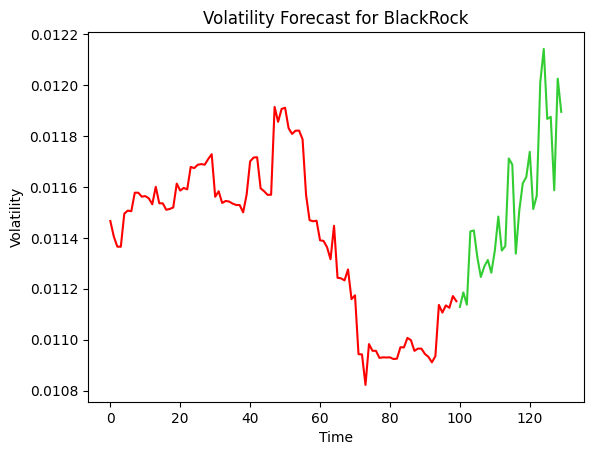

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Volatility Forecast for BlackRock")
ax.set_xlabel("Time")
ax.set_ylabel("Volatility")

# Change 'Volatility' to 'volatility' to match your earlier variable name
kVolatility = volatility[-100:]

# Change 'predicted_volatility' to 'predicted' to match your earlier variable name
ux = list(range(len(kVolatility)))
px = list(range(len(kVolatility), len(kVolatility)+len(predicted)))
ax.plot(ux, kVolatility, color='red')
ax.plot(px, predicted, color='limegreen')
plt.show()